In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis, skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from xgboost import XGBClassifier


In [3]:
# ---------------------
# 1) System Parameters
# ---------------------
SNR_dB = np.arange(-25, 6, 1)  # SNR range in dB
SNR_linear = 10 ** (SNR_dB / 10)

# Channel gains
h_u1_2 = 0.65
h_u2_2 = 2.7
h_oma_2 = 0.45

# Power allocation
alpha1 = 0.8
alpha2 = 0.2

# Detection parameters
Ns = 50
sigma_n2 = 1.0
alpha_cyclic = 0.1 # Dekho 
Pf_u1 = Pf_u2 = Pf_oma = 0.10
M1, M2 = 2, 2

# Monte Carlo parameters
num_samples = 10000

# Machine learning parameters
test_size = 0.2

# Cyclic lags for CAF
cyclic_lags = [18, 15]



In [4]:
# -------------------------------------------------
# 2) Cyclic Correlation Detection Functions
# -------------------------------------------------
def compute_cyclic_threshold(Pf, Ns, sigma_n2):
    return np.sqrt(2 * sigma_n2 / Ns) * norm.ppf(1 - Pf)

def cyclic_correlation_pd(SNR, alpha, h_2, Ns, lambda_val, sigma_n2, alpha_cyclic):
    signal_power = alpha * h_2 * SNR
    var_cyclic_H1 = (sigma_n2 + signal_power)**2 / Ns
    return 1 - norm.cdf((lambda_val - signal_power) / np.sqrt(var_cyclic_H1))



In [5]:
# -------------------------------------------------
# 3) ML Classifiers Setup
# -------------------------------------------------
def extract_features(received_signal):
    mag = np.abs(received_signal)
    
    # CAF features
    caf_values = []
    for lag in cyclic_lags:
        if lag < Ns:
            caf = np.mean(received_signal[:-lag] * np.conj(received_signal[lag:]))
            caf_values.append(np.abs(caf))
    caf_peak = max(caf_values) if caf_values else 0.0
    caf_variance = np.var(caf_values) if len(caf_values) > 1 else 0.0
    
    # Signal power estimate
    signal_power = max(np.mean(mag ** 2) - sigma_n2, 0)
    
    # Statistical features
    mag_kurtosis = kurtosis(mag)
    mag_skewness = skew(mag)
    
    return [
        np.mean(mag),
        np.std(mag),
        np.sum(mag ** 2),
        np.percentile(mag, 25),
        np.percentile(mag, 75),
        caf_peak,
        caf_variance,
        signal_power,
        mag_kurtosis,
        mag_skewness,
    ]

def generate_ml_data(snr_lin, num_samples):
    X, y = [], []

    for _ in range(num_samples):
        signal_present = np.random.rand() > 0.5

        if signal_present:
            x_u1 = np.sqrt(alpha1 * h_u1_2 * snr_lin) * np.random.randn(Ns)
            x_u2 = np.sqrt(alpha2 * h_u2_2 * snr_lin) * np.random.randn(Ns)
            signal = x_u1 + x_u2
        else:
            signal = np.zeros(Ns)

        noise = np.sqrt(sigma_n2 / 2) * (np.random.randn(Ns) + 1j * np.random.randn(Ns))
        received = signal + noise

        features = extract_features(received)
        X.append(features)
        y.append(signal_present)

    return np.array(X), np.array(y)

def train_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
        'SVM': SVC(probability=True, random_state=42)
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        results[name] = (fpr, tpr, roc_auc)

    return results



In [6]:

# -------------------------------------------------
# 4) Main Simulation
# -------------------------------------------------
Pd_u1, Pd_u2, Pd_oma = [], [], []
Pd_rf, Pd_lr, Pd_dt, Pd_xgb, Pd_svm = [], [], [], [], []

for idx, snr_db in enumerate(SNR_dB):
    snr_lin = SNR_linear[idx]

    # Compute thresholds for cyclic correlation detection
    lambda_noma = compute_cyclic_threshold(Pf_u1, Ns, sigma_n2)
    lambda_oma = compute_cyclic_threshold(Pf_oma, Ns, sigma_n2)

    pd_u1 = cyclic_correlation_pd(snr_lin, alpha1, h_u1_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_u2 = cyclic_correlation_pd(snr_lin, alpha2, h_u2_2, Ns, lambda_noma, sigma_n2, alpha_cyclic)
    pd_oma = cyclic_correlation_pd(snr_lin, 1.0, h_oma_2, Ns, lambda_oma, sigma_n2, alpha_cyclic)

    X, y = generate_ml_data(snr_lin, num_samples)
    results = train_classifiers(X, y)

    fpr_desired = 0.10
    pd_results = {}

    for name, (fpr, tpr, _) in results.items():
        if max(fpr) >= fpr_desired:
            interp_tpr = interp1d(fpr, tpr)
            pd_results[name] = float(interp_tpr(fpr_desired))
        else:
            pd_results[name] = 1.0

    Pd_u1.append(pd_u1)
    Pd_u2.append(pd_u2)
    Pd_oma.append(pd_oma)
    Pd_rf.append(pd_results.get('Random Forest', 0))
    Pd_lr.append(pd_results.get('Logistic Regression', 0))
    Pd_dt.append(pd_results.get('Decision Tree', 0))
    Pd_xgb.append(pd_results.get('XGBoost', 0))
    Pd_svm.append(pd_results.get('SVM', 0))

    print(f"SNR = {snr_db:3d} dB | U1-Pd = {pd_u1:.3f} | U2-Pd = {pd_u2:.3f} | OMA-Pd = {pd_oma:.3f}")
    print(f"ML Results: RF-Pd = {pd_results['Random Forest']:.3f}, LR-Pd = {pd_results['Logistic Regression']:.3f}, DT-Pd = {pd_results['Decision Tree']:.3f}, XGB-Pd = {pd_results['XGBoost']:.3f}, SVM-Pd = {pd_results['SVM']:.3f}\n")


SNR = -25 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.036
ML Results: RF-Pd = 0.113, LR-Pd = 0.086, DT-Pd = 0.102, XGB-Pd = 0.104, SVM-Pd = 0.094

SNR = -24 dB | U1-Pd = 0.036 | U2-Pd = 0.036 | OMA-Pd = 0.036
ML Results: RF-Pd = 0.075, LR-Pd = 0.109, DT-Pd = 0.095, XGB-Pd = 0.107, SVM-Pd = 0.100

SNR = -23 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.129, LR-Pd = 0.104, DT-Pd = 0.102, XGB-Pd = 0.102, SVM-Pd = 0.100

SNR = -22 dB | U1-Pd = 0.037 | U2-Pd = 0.037 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.118, LR-Pd = 0.127, DT-Pd = 0.107, XGB-Pd = 0.103, SVM-Pd = 0.129

SNR = -21 dB | U1-Pd = 0.038 | U2-Pd = 0.038 | OMA-Pd = 0.037
ML Results: RF-Pd = 0.132, LR-Pd = 0.123, DT-Pd = 0.100, XGB-Pd = 0.120, SVM-Pd = 0.121

SNR = -20 dB | U1-Pd = 0.039 | U2-Pd = 0.039 | OMA-Pd = 0.038
ML Results: RF-Pd = 0.098, LR-Pd = 0.111, DT-Pd = 0.093, XGB-Pd = 0.114, SVM-Pd = 0.101

SNR = -19 dB | U1-Pd = 0.040 | U2-Pd = 0.040 | OMA-Pd = 0.039
ML Results: RF-Pd = 0.119, LR-Pd

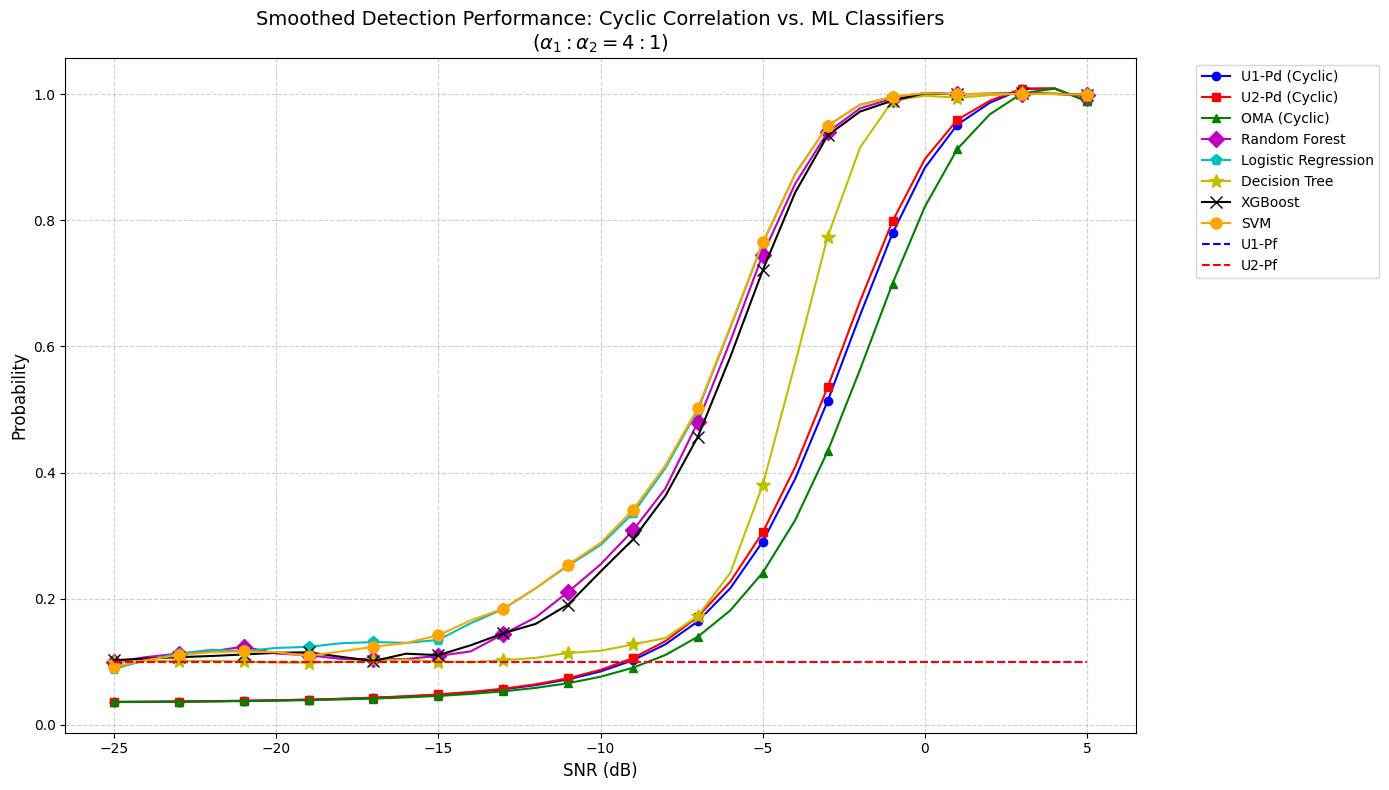

In [8]:

# -------------------------------------------------
# 5) Plot Results
# -------------------------------------------------
window_length = 7  # Must be odd
polyorder = 2

def smooth(data):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder)

Pd_u1_s = smooth(Pd_u1)
Pd_u2_s = smooth(Pd_u2)
Pd_oma_s = smooth(Pd_oma)
Pd_rf_s = smooth(Pd_rf)
Pd_lr_s = smooth(Pd_lr)
Pd_dt_s = smooth(Pd_dt)
Pd_xgb_s = smooth(Pd_xgb)
Pd_svm_s = smooth(Pd_svm)

plt.figure(figsize=(14, 8))
plt.plot(SNR_dB, Pd_u1_s, 'b-o', label='U1-Pd (Cyclic)', markevery=2)
plt.plot(SNR_dB, Pd_u2_s, 'r-s', label='U2-Pd (Cyclic)', markevery=2)
plt.plot(SNR_dB, Pd_oma_s, 'g-^', label='OMA (Cyclic)', markevery=2)
plt.plot(SNR_dB, Pd_rf_s, 'm-D', label='Random Forest', markevery=2, markersize=8)
plt.plot(SNR_dB, Pd_lr_s, 'c-p', label='Logistic Regression', markevery=2, markersize=8)
plt.plot(SNR_dB, Pd_dt_s, 'y-*', label='Decision Tree', markevery=2, markersize=10)
plt.plot(SNR_dB, Pd_xgb_s, 'k-x', label='XGBoost', markevery=2, markersize=8)
plt.plot(SNR_dB, Pd_svm_s, color='orange', marker='o', label='SVM', markevery=2, markersize=8)
plt.plot(SNR_dB, [Pf_u1] * len(SNR_dB), 'b--', label='U1-Pf')
plt.plot(SNR_dB, [Pf_u2] * len(SNR_dB), 'r--', label='U2-Pf')
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Smoothed Detection Performance: Cyclic Correlation vs. ML Classifiers\n($\\alpha_1 : \\alpha_2 = 4:1$)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()